In [298]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [299]:
dataset = pd.read_csv("dataset/SampleData.csv")
dataset.head(12)

,Ingredient,Product,QMerged_label,Real_Cost,V_0
0,1,1,11,10,0
1,1,2,12,6,0
2,2,1,21,8,0
3,2,2,22,11,0
4,3,1,31,3,0
5,3,2,32,7,0
6,4,1,41,8,0
7,4,2,42,5,0
8,4,3,43,1,0


In [300]:
class MonteCarlo:
    def __init__(self, dataset, num_episodes, epsilon, budget, reward, alpha):
        self.state_space = list(set(dataset['Ingredient']))
        self.alpha = alpha
        self.epsilon = epsilon
        self.budget = budget
        self.reward = reward
        self.num_episodes = num_episodes

    def run(self, dataset):
        v0 = dataset['V_0']
        dataset['V'] = v0
        output = []
        output1 = []
        output2 = []
        action_in_full = []

        for episode in range(self.num_episodes):
            
            if episode == 0:
                episode_run = np.random.randint(low=1, high=len(self.state_space) + 1, size=len(self.state_space))
                print(f'Episode Run: {episode_run}')

            else:
                episode_run = [
                    np.random.randint(low=1, high=sum(1 for p in dataset.iloc[:, 0] if p == i + 1))
                    if np.random.randint(low=1, high=11) <= (self.epsilon * 10)
                    else dataset[dataset['Ingredient'] == (i + 1)].nlargest(1, 'V')['Product'].values[0]
                    for i in range(len(self.state_space))
                ]

            episode_df = pd.DataFrame({'Ingredient': self.state_space, 'Product': episode_run})
            episode_df['Merged_label'] = (episode_df['Ingredient'] * 10 + episode_df['Product']).astype(float)
            dataset['QMerged_label'] = dataset['QMerged_label'].astype(float)
            dataset['Reward'] = self.reward

            episode2 = episode_df.merge(dataset[['QMerged_label', 'Real_Cost', 'Reward']],
                                        left_on='Merged_label', right_on='QMerged_label', how='inner')

            dataset = dataset.drop(columns='Reward')


            # reward function
            if self.budget >= episode2['Real_Cost'].sum():
                return_value = 1
            else:
                return_value = -1

            episode2 = episode2.drop(columns='Reward')
            episode2['Return'] = return_value
            dataset = dataset.merge(episode2[['Merged_label', 'Return']], left_on='QMerged_label',
                                    right_on='Merged_label', how='outer')
            dataset['Return'] = dataset['Return'].fillna(0)

            for v in range(len(dataset)):
                if dataset.iloc[v, 7] == 0:
                    dataset.iloc[v, 5] = dataset.iloc[v, 5]
                else:
                    dataset.iloc[v, 5] = dataset.iloc[v, 5] + self.alpha * (
                            (dataset.iloc[v, 7] / len(self.state_space)) - dataset.iloc[v, 5])

            dataset = dataset.drop(columns='Merged_label')
            dataset = dataset.drop(columns='Return')

            output = np.append(output, dataset.iloc[:, -1].sum())
            output1 = np.append(output1, dataset.iloc[[1, 2, 4, 8], -1].sum())
            output2 = np.append(output2, dataset.iloc[[0, 3, 5, 6, 7], -1].sum())

            action = pd.DataFrame(dataset.groupby('Ingredient')['V'].max())
            action2 = action.merge(dataset, left_on='V', right_on='V', how='inner')
            action3 = action2.groupby('Ingredient')['Product'].apply(
                lambda x: x.iloc[np.random.randint(0, len(x))])

            action_in_full = np.append(action_in_full, action3)
            action_in_full = action_in_full.astype(int)

        return output, output1, output2, action3, dataset, action_in_full
            

In [301]:
alpha = 0.1
epsilon = 0.1
budget = 100
reward = [0,0,0,0,0,0,0,0,0]
num_episodes = 100

monte_carlo = MonteCarlo(dataset, num_episodes, epsilon, budget, reward, alpha)
# Run Monte Carlo simulation
output, output1, output2, optimal_actions, updated_data, actions_selected_in_time = monte_carlo.run(dataset)

# Print the results
print("Optimal actions:", optimal_actions)

Episode Run: [2 4 4 1]


Optimal actions: Ingredient
1    2
2    1
3    1
4    1
Name: Product, dtype: int64


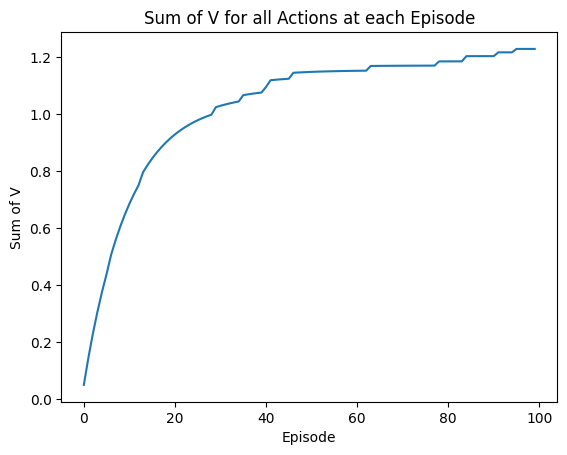

In [302]:
import matplotlib.pyplot as plt

plt.plot(range(0,num_episodes), output)
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

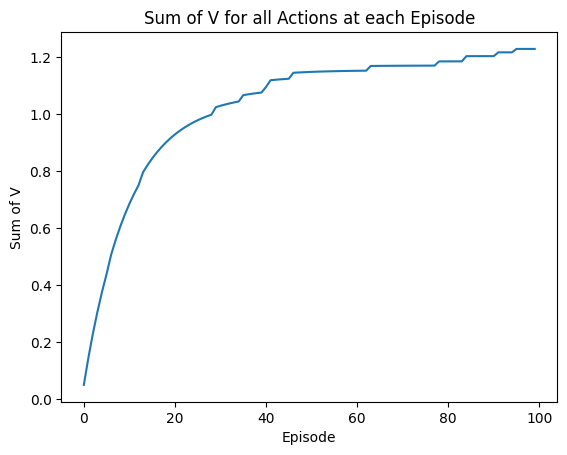

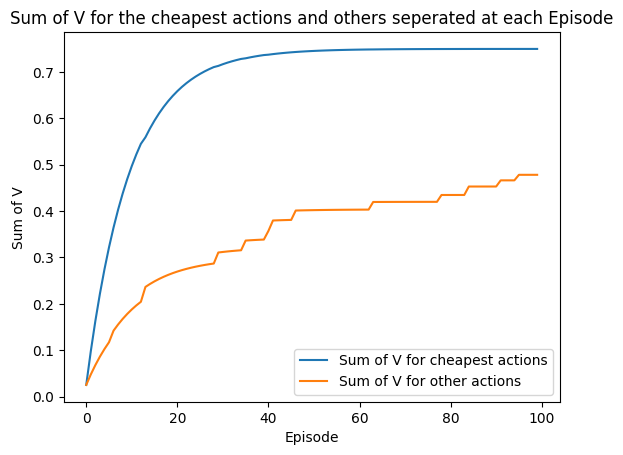

In [303]:
plt.plot(range(0,num_episodes), output)
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()



plt.plot(range(0, num_episodes), output1, label='Sum of V for cheapest actions')
plt.plot(range(0, num_episodes), output2, label='Sum of V for other actions')

plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.legend(loc="lower right")
plt.show()